Import price data to train and test on

In [176]:
import pandas as pd

prices = pd.read_excel('Price.xlsx')
prices = prices.loc[prices['PriceArea'] == 'DK1']
prices = prices['PriceDKK'].values

# Temporarily limit the number of prices to 100
prices = prices[:6000]

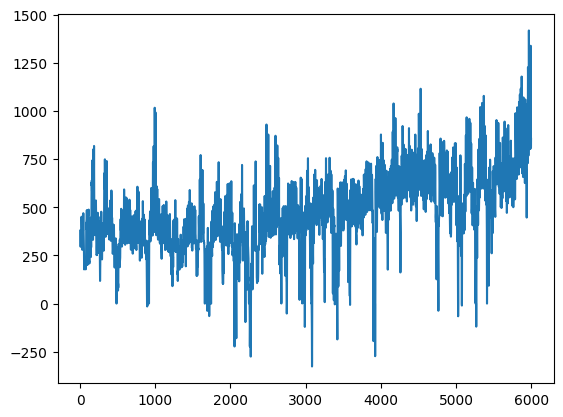

In [177]:
import matplotlib.pyplot as plt
plt.plot(prices)

Define actions and states, and allowed actions in different states. Only depends on SOC

In [188]:
import numpy as np

ACTIONS = ["Charge", "Discharge", "Do nothing"]
PRICE_STATE = ["Lowest", "Lower", "Medium", "Higher", "Highest"]
SOC_STATE = ["20%", "40%", "60%", "80%", "100%"]
ALLOWED_ACTIONS = {"20%":  ["Charge",              "Do nothing"], 
                   "40%":  ["Charge", "Discharge", "Do nothing"],
                   "60%":  ["Charge", "Discharge", "Do nothing"],
                   "80%":  ["Charge", "Discharge", "Do nothing"],
                   "100%": [          "Discharge", "Do nothing"],}

# Initialize the lookup-table
P_ssa = np.empty((len(PRICE_STATE), len(SOC_STATE), len(ACTIONS)), dtype=object)

Prepare and estimate probability of transitioning from one price state to another

In [217]:
# Split prices into 5 states
percentiles = np.percentile(prices, np.linspace(0, 100, len(PRICE_STATE) + 1))
price_states = np.array([(percentiles[i] <= prices) & (prices < percentiles[i+1]) for i in range(len(PRICE_STATE))], dtype=int)


# Compute probability of being in a price state given the current price state.
# Assumed independent of SOC state and action
# price_prop = P(s'|s) -> price_prop[i,j] = P(s'=j|s=i)
price_prop = (price_states @ np.roll(price_states,-1).T) / (price_states).sum(axis=1)


# Generate representative prices
price_representative = np.array([prices[price_states[i] == 1].mean() for i in range(len(PRICE_STATE))])

Compute the transitioning matrix for each given state (price and SOC) and action. Limit allowed actions

In [219]:
for i, ps in enumerate(PRICE_STATE):
    for j, ss in enumerate(SOC_STATE):
        for k, ac in enumerate(ACTIONS):
            # Given that we are in state ps, ss and take action ac
            # what is the probability of transitioning to each state (ps', ss')
            # i.e. P(s'=(ps', ss')| s=(ps, ss), ac)
            if ac in ALLOWED_ACTIONS[ss]:
                if ac == "Charge":
                    c = 1
                elif ac == "Discharge":
                    c = -1
                else:
                    c = 0
                SOC_prop = np.zeros((len(SOC_STATE)))
                SOC_prop[j+c] = 1
                # state_trans = P(price'|price) * P(soc'|soc, action)
                state_trans = price_prop[i,:].reshape(-1,1) @ SOC_prop.reshape(1,-1)
                P_ssa[i,j,k] = state_trans
            else:
                P_ssa[i,j,k] = np.zeros((len(PRICE_STATE), len(SOC_STATE)))

Generate reward function

In [220]:
def rewards(price_state, action):
    if action == "Charge":
        reward = - 100 * price_representative[PRICE_STATE.index(price_state)]
    elif action == "Discharge":
        reward = 100 * price_representative[PRICE_STATE.index(price_state)]
    else:
        reward = 0
    return reward

In [221]:
def value_iteration(gamma = 0.9, epsilon=1e-6):
    # Initialize the value function with V(s) = 0
    V = np.ones((len(PRICE_STATE), len(SOC_STATE)))*0
    V_list = []
    V_list.append(V)
    V_new_list = []
    count = 0
    while True:
        # Initialize the new value function
        V_new = np.zeros((len(PRICE_STATE), len(SOC_STATE)))
        V_new_list.append(V_new)
        for i, ps in enumerate(PRICE_STATE):
            for j, ss in enumerate(SOC_STATE):
                # print(f"Allowed actions for SOC_STATE {ss}: {ALLOWED_ACTIONS[ss]}")
                # Update the value function
                V_new[i,j] = np.max([rewards(ps, ac) + gamma * np.sum(P_ssa[i,j,k] * V) for k, ac in enumerate(ACTIONS) if ac in ALLOWED_ACTIONS[ss]])
            # Check for convergence
        if np.max(np.abs(V - V_new)) < epsilon:
            print(f"Converged after {count} iterations")
            break
        # print(f"Iteration {count}: max change = {np.max(np.abs(V - V_new))}")
        V = V_new
        V_list.append(V)
        count += 1
        
        

    return V, count, V_list, V_new_list

In [222]:
V, count, V_list, V_new_list = value_iteration()
np.round(V,0)

Converged after 4 iterations


array([[     0.,  18816.,  37524.,  55779.,  73363.],
       [     0.,  35386.,  67235.,  96099., 122370.],
       [     0.,  44543.,  84787., 121200., 154134.],
       [     0.,  56160., 107417., 153654., 195100.],
       [     0.,  75008., 139802., 196141., 245354.]])

In [232]:
import numpy as np

def value_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, rewards, P_ssa, gamma=0.9, epsilon=1e-6):
    """
    Perform value iteration for a 2D state space with given parameters.

    Parameters:
    - PRICE_STATE: List of discrete price states
    - SOC_STATE: List of discrete state of charge (SOC) states
    - ALLOWED_ACTIONS: A dictionary mapping each SOC state to a list of valid actions
    - rewards: A function `rewards(price_state, action)` that returns the immediate reward
    - P_ssa: Transition probability matrix of shape (len(PRICE_STATE), len(SOC_STATE), len(actions), len(PRICE_STATE), len(SOC_STATE))
    - gamma: Discount factor (default 0.9)
    - epsilon: Convergence threshold (default 1e-6)

    Returns:
    - V: Optimal value function of shape (len(PRICE_STATE), len(SOC_STATE))
    - policy: Optimal policy for each state, of shape (len(PRICE_STATE), len(SOC_STATE))
    """
    # Initialize the value function to 0 for all states
    V = np.zeros((len(PRICE_STATE), len(SOC_STATE)))
    policy = np.zeros((len(PRICE_STATE), len(SOC_STATE)), dtype=object)
    V_list = []
    V_list.append(V)
    V_new_list = []
    count = 0
    while True:
        # Initialize the new value function
        V_new = np.zeros((len(PRICE_STATE), len(SOC_STATE)))
        V_new_list.append(V_new)
        
        for i, ps in enumerate(PRICE_STATE):  # Iterate over price states
            for j, ss in enumerate(SOC_STATE):  # Iterate over SOC states
                # Get the valid actions for the current SOC state
                valid_actions = ALLOWED_ACTIONS[ss]

                # Compute the expected value for each valid action
                action_values = []
                for k, action in enumerate(ACTIONS):
                    if action in ALLOWED_ACTIONS[ss]:
               
                        immediate_reward = rewards(ps, action)

                        # Compute the expected future value
                        expected_future_value = 0
                        for i_next, ps_next in enumerate(PRICE_STATE):
                            for j_next, ss_next in enumerate(SOC_STATE):
                                expected_future_value += P_ssa[i, j, k][i_next, j_next] * V[i_next, j_next]

                        # Combine immediate reward and discounted future value
                        action_value = immediate_reward + gamma * expected_future_value
                        action_values.append(action_value)

                # Update the value function with the max action value
                V_new[i, j] = max(action_values)

                # Store the optimal action index
                policy[i, j] = valid_actions[np.argmax(action_values)]

        # Check for convergence
        count += 1
        if np.max(np.abs(V - V_new)) < epsilon:
            print(f"Converged after {count} iterations")
            break

        # Update the value function
        V = V_new

    return V, policy, count, V_list, V_new_list

In [244]:
V, policy, count, V_list, V_new_list = value_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, rewards, P_ssa, gamma=0.994, epsilon=1e-6)
policy

Converged after 3414 iterations


array([['Charge', 'Charge', 'Charge', 'Charge', 'Do nothing'],
       ['Charge', 'Charge', 'Do nothing', 'Discharge', 'Discharge'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge'],
       ['Charge', 'Do nothing', 'Discharge', 'Discharge', 'Discharge'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge']],
      dtype=object)

In [ ]:
np.round(price_prop[3], 2)

array([0.  , 0.01, 0.15, 0.69, 0.15])